In [1]:
import argparse
import math
import os
import random
import gym
import numpy as np
import json

# Follow instructions here to install https://github.com/openai/roboschool
#import roboschool

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from lib.common import mkdir
#from lib.model import ActorCritic
import lib.model as models
from lib.multiprocessing_env import SubprocVecEnv
from lib.environment import atari_env
from lib.config import setup

def make_env(env_id):
    # returns a function which creates a single environment
    def _thunk():
        #env = gym.make(env_id)
        env = atari_env(env_id)
        return env
    return _thunk

def test_env(env, model, device, deterministic=True):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)

        if isinstance(dist, torch.distributions.categorical.Categorical):
            action = np.argmax(dist.probs.detach().cpu().numpy()) if deterministic \
                else int(dist.sample().cpu().numpy())

        elif isinstance(dist, torch.distributions.normal.Normal):
            action = dist.mean.detach().cpu().numpy()[0] if deterministic \
                else dist.sample().cpu().numpy()[0]
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    return total_reward


def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x

def compute_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * \
            values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * lam * masks[step] * gae
        # prepend to get correct order back
        returns.insert(0, gae + values[step])
    return returns

def ppo_iter(states, actions, log_probs, returns, advantage, mini_batch_size):
    batch_size = states.shape[0]
    # generates random mini-batches until we have covered the full batch
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(frame_idx, states, actions, log_probs, returns, advantages, clip_param, 
    epochs, mini_batch_size, critic_discount, entropy_beta, device):

    count_steps = 0
    sum_returns = 0.0
    sum_advantage = 0.0
    sum_loss_actor = 0.0
    sum_loss_critic = 0.0
    sum_entropy = 0.0
    sum_loss_total = 0.0

    # PPO EPOCHS is the number of times we will go through ALL the training data to make updates    
    for _ in range(epochs):
        # grabs random mini-batches several times until we have covered all data
        for state, action, old_log_probs, return_, advantage in ppo_iter(states, actions, log_probs, returns, advantages, mini_batch_size):
            
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            old_log_probs = torch.FloatTensor(old_log_probs).to(device)
            advantage = torch.FloatTensor(advantage).to(device)
            return_ = torch.FloatTensor(return_).to(device)

            dist, value = model(state)
            
            entropy = dist.entropy().mean()
            #new_log_probs = dist.log_prob(action)
            new_log_probs = dist.log_prob(action.squeeze()).unsqueeze(dim=1)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param,
                                1.0 + clip_param) * advantage

            actor_loss = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = critic_discount * critic_loss + actor_loss - entropy_beta * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # track statistics
            sum_returns += return_.mean()
            sum_advantage += advantage.mean()
            sum_loss_actor += actor_loss
            sum_loss_critic += critic_loss
            sum_loss_total += loss
            sum_entropy += entropy

            count_steps += 1

    writer.add_scalar("returns", sum_returns / count_steps, frame_idx)
    writer.add_scalar("advantage", sum_advantage / count_steps, frame_idx)
    writer.add_scalar("loss_actor", sum_loss_actor / count_steps, frame_idx)
    writer.add_scalar("loss_critic", sum_loss_critic / count_steps, frame_idx)
    writer.add_scalar("entropy", sum_entropy / count_steps, frame_idx)
    writer.add_scalar("loss_total", sum_loss_total / count_steps, frame_idx)


In [2]:
    conf = setup('BreakoutNoFrameskip-v4')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Device:', device)

    # Prepare environments
    envs = [make_env(conf.ENV_ID) for i in range(conf.NUM_ENVS)]
    envs = SubprocVecEnv(envs)
    
    env = atari_env(conf.ENV_ID)
    
    num_inputs = conf.NUM_INPUTS #envs.observation_space
    num_outputs = conf.NUM_OUTPUTS #envs.action_space

    model = conf.MODEL_CLASS(num_inputs, num_outputs, hidden_size=conf.HIDDEN_SIZE).to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=conf.LEARNING_RATE)

    frame_idx = 0
    train_epoch = 0
    best_reward = None

    state = envs.reset()
    early_stop = False

    log_probs = []
    values = []
    states = []
    actions = []
    rewards = []
    masks = []


Device: cuda
ActorCriticLSTM(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTMCell(1024, 512)
  (critic_linear): Linear(in_features=512, out_features=1, bias=True)
  (actor_linear): Linear(in_features=512, out_features=4, bias=True)
  (logsoftmax): LogSoftmax()
)


In [3]:
for _ in range(conf.PPO_STEPS):
            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)
            
            action = dist.sample()
            
            # each state, reward, done is a list of results from each parallel environment
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            
            log_prob = dist.log_prob(action)

            # Save Episodes
            log_probs.append(log_prob.cpu().detach().numpy())
            values.append(value.cpu().detach().numpy())
            rewards.append(np.expand_dims(reward, 1))
            masks.append(np.expand_dims(1-done, 1))
            states.append(state.cpu().detach().numpy())
            actions.append(action.cpu().detach().numpy())

            state = next_state
            frame_idx += 1


In [10]:
import matplotlib.pyplot as plt

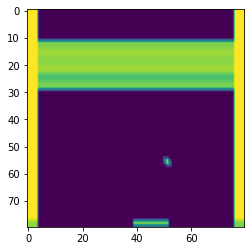

In [43]:
plt.imshow(states[138][0][0])

In [7]:
advantages = returns - values
advantages = normalize(advantages)

In [8]:
if len(log_probs.shape) == 1:
            log_probs = np.expand_dims(log_probs, 1)

if len(actions.shape) == 1:
            actions = np.expand_dims(actions, 1)

In [10]:
for state, action, old_log_probs, return_, advantage in ppo_iter(states, actions, log_probs, returns, advantages, 128):
    break

In [11]:
    count_steps = 0
    sum_returns = 0.0
    sum_advantage = 0.0
    sum_loss_actor = 0.0
    sum_loss_critic = 0.0
    sum_entropy = 0.0
    sum_loss_total = 0.0

In [12]:
state = torch.FloatTensor(state).to(device)

In [14]:
dist, value = model(state)

In [15]:
entropy = dist.entropy().mean()

In [25]:
action = torch.FloatTensor(action).to(device)


tensor([[3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [0.],
      

In [28]:
new_log_probs = dist.log_prob(action.squeeze()).unsqueeze(dim=1)

In [30]:
new_log_probs.size()

torch.Size([128, 1])

In [33]:
old_log_probs = torch.FloatTensor(old_log_probs).to(device)

In [37]:
ratio = (new_log_probs - old_log_probs).exp()

In [40]:
advantage = torch.FloatTensor(advantage).to(device)

In [41]:
surr1 = ratio * advantage

In [44]:
surr2 = torch.clamp(ratio, 1.0 - 0.2, 1.0 + 0.2) * advantage

In [46]:
actor_loss = - torch.min(surr1, surr2).mean()

In [51]:
return_ = torch.FloatTensor(return_).to(device)

In [52]:
critic_loss = (return_ - value).pow(2).mean()

In [56]:
loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

In [57]:
loss

tensor(0.0139, device='cuda:0', grad_fn=<SubBackward0>)

In [58]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [59]:
sum_returns += return_.mean()
sum_advantage += advantage.mean()
sum_loss_actor += actor_loss
sum_loss_critic += critic_loss
sum_loss_total += loss
sum_entropy += entropy


In [60]:
sum_returns

tensor(0.0534, device='cuda:0')

In [116]:
ppo_update(frame_idx, states, actions, log_probs, returns, advantage,
            conf.PPO_EPSILON, conf.PPO_EPOCHS, conf.MINI_BATCH_SIZE, conf.CRITIC_DISCOUNT, conf.ENTROPY_BETA, device)

TypeError: 'int' object is not callable